In [ ]:
!pip install colorama -q
!pip install transformers -q
!pip install tokenizers -q
!pip install SentencePiece -q

     |████████████████████████████████| 4.4 MB 7.9 MB/s 
     |████████████████████████████████| 101 kB 7.6 MB/s 
     |████████████████████████████████| 596 kB 26.9 MB/s 
     |████████████████████████████████| 6.6 MB 46.7 MB/s 
     |████████████████████████████████| 1.2 MB 7.2 MB/s 


In [ ]:
import json
import os
import re
import sys

import requests
import string
import numpy as np
from colorama import Fore
from tokenizers import BertWordPieceTokenizer
from tqdm import tqdm
from transformers import CamembertTokenizer, CamembertModel, BertModel, BertTokenizer
import torch
import torch.nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir "/content/camembertLSTMFquad"

In [ ]:
!unzip "/content/drive/MyDrive/download-form-fquad1.0.zip" -d "/content/fquad/"

Archive:  /content/drive/MyDrive/download-form-fquad1.0.zip
  inflating: /content/fquad/train.json  
  inflating: /content/fquad/__MACOSX/._train.json  
  inflating: /content/fquad/valid.json  
  inflating: /content/fquad/__MACOSX/._valid.json  


In [ ]:
class Config:
  DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  MAX_SEQ_LENGTH = 384
  BATCH_SIZE = 2
  EPOCHS = 3

In [ ]:
def read_squad(path):
    with open(path, 'rb') as f:
        squad_dict = json.load(f)

    # initialize lists for contexts, questions, and answers
    contexts = []
    questions = []
    answers = []
    # iterate through all data in squad data
    for group in squad_dict['data']:
        for passage in group['paragraphs']:
            context = passage['context']
            for qa in passage['qas']:
                question = qa['question']
                if 'plausible_answers' in qa.keys():
                    access = 'plausible_answers'
                else:
                    access = 'answers'
                for answer in qa['answers']:
                    # append data to lists
                    contexts.append(context)
                    questions.append(question)
                    answers.append(answer)
    # return formatted data lists
    return contexts, questions, answers

In [ ]:

train_contexts, train_questions, train_answers = read_squad('/content/fquad/train.json')
val_contexts, val_questions, val_answers = read_squad('/content/fquad/valid.json')

In [ ]:
def add_end_idx(answers, contexts):
    # loop through each answer-context pair
    for answer, context in zip(answers, contexts):
        # gold_text refers to the answer we are expecting to find in context
        gold_text = answer['text']
        # we already know the start index
        start_idx = answer['answer_start']
        # and ideally this would be the end index...
        end_idx = start_idx + len(gold_text)

        # ...however, sometimes squad answers are off by a character or two
        if context[start_idx:end_idx] == gold_text:
            # if the answer is not off :)
            answer['answer_end'] = end_idx
        else:
            for n in [1, 2]:
                if context[start_idx-n:end_idx-n] == gold_text:
                    # this means the answer is off by 'n' tokens
                    answer['answer_start'] = start_idx - n
                    answer['answer_end'] = end_idx - n

In [ ]:
add_end_idx(train_answers, train_contexts)
add_end_idx(val_answers, val_contexts)

In [ ]:
train_answers[855]['answer_end']=429
train_answers[854]['answer_end']=339

Encode

In [ ]:
train_contexts[:3]

["L'idée selon laquelle une planète inconnue pourrait exister entre les orbites de Mars et Jupiter fut proposée pour la première fois par Johann Elert Bode en 1768. Ses suggestions étaient basées sur la loi de Titius-Bode, une théorie désormais obsolète proposée par Johann Daniel Titius en 1766,. Selon cette loi, le demi-grand axe de cette planète aurait été d'environ 2,8 ua. La découverte d'Uranus par William Herschel en 1781 accrut la confiance dans la loi de Titius-Bode et, en 1800, vingt-quatre astronomes expérimentés combinèrent leurs efforts et entreprirent une recherche méthodique de la planète proposée,. Le groupe était dirigé par Franz Xaver von Zach. Bien qu'ils n'aient pas découvert Cérès, ils trouvèrent néanmoins plusieurs autres astéroïdes.",
 "L'idée selon laquelle une planète inconnue pourrait exister entre les orbites de Mars et Jupiter fut proposée pour la première fois par Johann Elert Bode en 1768. Ses suggestions étaient basées sur la loi de Titius-Bode, une théorie

In [ ]:
train_questions[:3]

["Quel astronome a émit l'idée en premier d'une planète entre les orbites de Mars et Jupiter ?",
 'Quel astronome découvrit Uranus ?',
 'Quelles furent les découvertes finales des vingt-quatre astronomes ?']

In [ ]:
from transformers import CamembertTokenizer, CamembertTokenizerFast
from transformers import CamembertModel
tokenizer = CamembertTokenizerFast.from_pretrained('camembert-base')

train_encodings = tokenizer(train_contexts, train_questions, truncation=True, padding=True)
val_encodings = tokenizer(val_contexts, val_questions, truncation=True, padding=True)

Downloading:   0%|          | 0.00/792k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.33M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/508 [00:00<?, ?B/s]

In [ ]:
def add_token_positions(encodings, answers):
    # initialize lists to contain the token indices of answer start/end
    start_positions = []
    end_positions = []
    for i in range(len(answers)):
        # append start/end token position using char_to_token method
        start_positions.append(encodings.char_to_token(i, answers[i]['answer_start']))
        end_positions.append(encodings.char_to_token(i, answers[i]['answer_end']))

        # if start position is None, the answer passage has been truncated
        if start_positions[-1] is None:
            start_positions[-1] = tokenizer.model_max_length
        # end position cannot be found, char_to_token found space, so shift one token forward
        go_back = 1
        while end_positions[-1] is None:
            end_positions[-1] = encodings.char_to_token(i, answers[i]['answer_end']-go_back)
            go_back +=1
    # update our encodings object with the new token-based start/end positions
    encodings.update({'start_positions': start_positions, 'end_positions': end_positions})



In [ ]:
# apply function to our data
add_token_positions(val_encodings, val_answers)
add_token_positions(train_encodings, train_answers)

Model : Camembert + LSTM


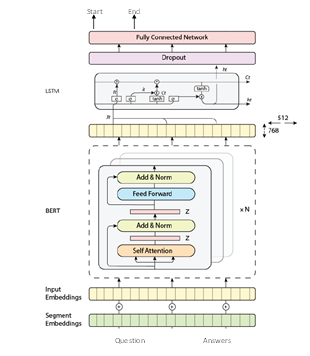

In [ ]:
import torch

class FquadDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

train_dataset = FquadDataset(train_encodings)
val_dataset = FquadDataset(val_encodings)

In [ ]:
import torch
from torch import nn
from torch.nn import CrossEntropyLoss

import transformers
 
class CamemBertLSTMForQuestionAnswering(nn.Module):
    def __init__(self):
        super(CamemBertLSTMForQuestionAnswering, self).__init__()
        self.camembert = CamembertModel.from_pretrained('camembert-base', return_dict=False, add_pooling_layer=False)

        # Add LSTM on top of BERT
        self.lstm = nn.LSTM(768, 256, batch_first=True)

         # Add dropout to prevent overfitting.
        self.dropout = nn.Dropout(0.2)
        self.qa_outputs = nn.Linear(256, 2)


    def forward(self, input_ids, token_type_ids=None, attention_mask=None, start_positions=None, end_positions=None):
        outputs = self.camembert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        lstm_output, (h, c) = self.lstm(outputs[0])
        sequence_output = self.dropout(lstm_output) # All the lstm hidden states of tokens should be there, because it is token level classification task
        
        logits = self.qa_outputs(sequence_output)

        start_logits, end_logits = logits.split(1, dim=-1)
        start_logits = start_logits.squeeze(-1)
        end_logits = end_logits.squeeze(-1)

        if start_positions is not None and end_positions is not None:
            # If we are on multi-GPU, split add a dimension
            if len(start_positions.size()) > 1:
                start_positions = start_positions.squeeze(-1)
            if len(end_positions.size()) > 1:
                end_positions = end_positions.squeeze(-1)
            # sometimes the start/end positions are outside our model inputs, we ignore these terms
            ignored_index = start_logits.size(1)
            start_positions.clamp_(0, ignored_index)
            end_positions.clamp_(0, ignored_index)

            loss_fct = nn.CrossEntropyLoss(ignore_index=ignored_index)
            start_loss = loss_fct(start_logits, start_positions)
            end_loss = loss_fct(end_logits, end_positions)
            total_loss = (start_loss + end_loss) / 2

            output = (start_logits, end_logits) + outputs[2:]
            return ((total_loss,) + output) if total_loss is not None else output
        else:
            return start_logits, end_logits

In [ ]:
# Model
model = CamemBertLSTMForQuestionAnswering().to(device=Config.DEVICE)

Downloading:   0%|          | 0.00/424M [00:00<?, ?B/s]

Some weights of the model checkpoint at camembert-base were not used when initializing CamembertModel: ['lm_head.dense.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing CamembertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
def normalize_text(text):
  text = text.lower()
  text = text.replace("'"," ")
  text = "".join(ch for ch in text if ch not in set(string.punctuation))
  regex = re.compile(r"\b(un|une|le|la|l|de|des|par|avec)\b", re.UNICODE)
  text = re.sub(regex, " ", text)
  #text = " ".join(text.split())
  return text.split()

In [ ]:
def compute_f1(prediction, truth):
    
    pred_tokens = normalize_text(prediction)
    truth_tokens = normalize_text(truth)
    
    # if either the prediction or the truth is no-answer then f1 = 1 if they agree, 0 otherwise
    if len(pred_tokens) == 0 or len(truth_tokens) == 0:
        return int(pred_tokens == truth_tokens)
    
    common_tokens = set(pred_tokens) & set(truth_tokens)
    
    # if there are no common tokens then f1 = 0
    if len(common_tokens) == 0:
        return 0
    
    prec = len(common_tokens) / len(pred_tokens)
    rec = len(common_tokens) / len(truth_tokens)
    
    return 2 * (prec * rec) / (prec + rec)

In [ ]:
from torch.utils.data import DataLoader
from transformers import AdamW
from tqdm import tqdm
from statistics import mean

# setup GPU/CPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# move model over to detected device
#model.to(device)
# activate training mode of model
model.train()
# initialize adam optimizer with weight decay (reduces chance of overfitting)
optim = AdamW(model.parameters(), lr=3e-5)

# initialize data loader for training data
train_loader = DataLoader(train_dataset, batch_size=Config.BATCH_SIZE, shuffle=True)
#val_sampler = SequentialSampler(val_dataset)
val_loader = DataLoader(val_dataset, batch_size=Config.BATCH_SIZE)

for epoch in range(1, Config.EPOCHS ):
    

# ============================================ Training ==========================================================

    # set model to train mode
    model.train()
    # setup loop (we use tqdm for the progress bar)
    loop = tqdm(train_loader, leave=True)
    for batch in loop:
        # initialize calculated gradients (from prev step)
        optim.zero_grad()
        # pull all the tensor batches required for training
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        start_positions = batch['start_positions'].to(device)
        end_positions = batch['end_positions'].to(device)
        # train model on batch and return outputs (incl. loss)
        outputs = model(input_ids, attention_mask=attention_mask,
                        start_positions=start_positions,
                        end_positions=end_positions)
        # extract loss
        loss = outputs[0]
        # calculate loss for every parameter that needs grad update
        loss.backward()
        # update parameters
        optim.step()
        # print relevant info to progress bar
        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(loss=loss.item())
    torch.save(model.state_dict(), "./camembertLSTMFquad/weights_" + str(epoch) + ".pth")

# ============================================ VALIDATION ==========================================================

    # switch model out of training mode
    model.eval()

    #answers = val_answers
    #context = val_contexts
    currentIdx = 0

    acc = []
    f1_scores=[]

    # initialize loop for progress bar
    loop = tqdm(val_loader)
    # loop through batches
    for batch in loop:
        # we don't need to calculate gradients as we're not training
        with torch.no_grad():
            # pull batched items from loader
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            start_true = batch['start_positions'].to(device).detach().cpu().numpy()
            end_true = batch['end_positions'].to(device).detach().cpu().numpy()
            # make predictions
            outputs = model(input_ids, attention_mask=attention_mask)
            # pull preds out
            start_pred = torch.argmax(outputs[0], dim=1).detach().cpu().numpy()
            end_pred = torch.argmax(outputs[1], dim=1).detach().cpu().numpy()

            for idx, (start, end) in enumerate(zip(start_pred, end_pred)):
              #context = val_contexts[currentIdx]
              pred_answer = tokenizer.decode(list(val_encodings['input_ids'][currentIdx])[start:end+1])
              #pred_answer = context[start:end]
              true_answer = tokenizer.decode(list(val_encodings['input_ids'][currentIdx])[start_true[idx]:end_true[idx]+1])
              #true_answer = val_answers[currentIdx]["text"]
              currentIdx += 1
              f1_score = compute_f1(pred_answer, true_answer)
              f1_scores.append(f1_score)
    #print(f1_scores)
    f1 = mean(f1_scores)*100
    print(f"\nEpoch={epoch},   F1-score = {f1:.4f}")

            # calculate accuracy for both and append to accuracy list
            #acc.append(((start_pred == start_true).sum()/len(start_pred)).item())
            #acc.append(((end_pred == end_true).sum()/len(end_pred)).item())
    # calculate average accuracy in total
    #acc = sum(acc)/len(acc)'''
    #print(f"\nEpoch={epoch}, exact match score={acc:.2f}")

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
100%|██████████| 1594/1594 [01:15<00:00, 20.99it/s]



Epoch=1,   F1-score = 76.6881


100%|██████████| 1594/1594 [01:15<00:00, 21.02it/s]


Epoch=2,   F1-score = 77.8778


# Exemple

In [ ]:
"""Le réchauffement planétaire atteindra les 1,5 °C entre 2030 et 2052 si la température continue d’augmenter à ce rythme. 
    Le RS15 (rapport spécial sur le réchauffement climatique de 1,5 °C) résume, d’une part, les recherches existantes sur 
    l’impact qu’un réchauffement de 1,5 °C aurait sur la planète et, d’autre part, les mesures nécessaires pour limiter 
    ce réchauffement planétaire. Même en supposant la mise en œuvre intégrale des mesures déterminées au niveau national 
    soumises par les pays dans le cadre de l’Accord de Paris, les émissions nettes augmenteraient par rapport à 2010, entraînant 
    un réchauffement d’environ 3 °C d’ici 2100, et davantage par la suite. En revanche, pour limiter le réchauffement 
    au-dessous ou proche de 1,5 °C, il faudrait diminuer les émissions nettes d’environ 45 % d’ici 2030 et atteindre 0 % en 2050. 
    Même pour limiter le réchauffement climatique à moins de 2 °C, les émissions de CO2 devraient diminuer de 25 % d’ici 2030 et de 100 % d’ici 2075. 
    Les scénarios qui permettraient une telle réduction d’ici 2050 ne permettraient de produire qu’environ 8 % de l’électricité mondiale 
    par le gaz et 0 à 2 % par le charbon (à compenser par le captage et le stockage du dioxyde de carbone). Dans ces filières, les énergies renouvelables 
    devraient fournir 70 à 85 % de l’électricité en 2050 et la part de l’énergie nucléaire est modélisée pour augmenter. 
    Il suppose également que d’autres mesures soient prises simultanément : par exemple, les émissions autres que le CO2 (comme le méthane, 
    le noir de carbone, le protoxyde d’azote) doivent être réduites de manière similaire, la demande énergétique reste inchangée, voire 
    réduite de 30 % ou compensée par des méthodes sans précédentes d’élimination du dioxyde de carbone à mettre au point, tandis que de nouvelles 
    politiques et recherches permettent d’améliorer l’efficacité de l’agriculture et de l’industrie."""



In [ ]:
passage = ["Le réchauffement planétaire atteindra les 1,5 °C entre 2030 et 2052 si la température continue d’augmenter à ce rythme. Le RS15 (rapport spécial sur le réchauffement climatique de 1,5 °C) résume, d’une part, les recherches existantes sur l’impact qu’un réchauffement de 1,5 °C aurait sur la planète et, d’autre part, les mesures nécessaires pour limiter ce réchauffement planétaire. Même en supposant la mise en œuvre intégrale des mesures déterminées au niveau national soumises par les pays dans le cadre de l’Accord de Paris, les émissions nettes augmenteraient par rapport à 2010, entraînant un réchauffement d’environ 3 °C d’ici 2100, et davantage par la suite. En revanche, pour limiter le réchauffement au-dessous ou proche de 1,5 °C, il faudrait diminuer les émissions nettes d’environ 45 % d’ici 2030 et atteindre 0 % en 2050. Même pour limiter le réchauffement climatique à moins de 2 °C, les émissions de CO2 devraient diminuer de 25 % d’ici 2030 et de 100 % d’ici 2075. Les scénarios qui permettraient une telle réduction d’ici 2050 ne permettraient de produire qu’environ 8 % de l’électricité mondiale par le gaz et 0 à 2 % par le charbon (à compenser par le captage et le stockage du dioxyde de carbone). Dans ces filières, les énergies renouvelables devraient fournir 70 à 85 % de l’électricité en 2050 et la part de l’énergie nucléaire est modélisée pour augmenter. Il suppose également que d’autres mesures soient prises simultanément : par exemple, les émissions autres que le CO2 (comme le méthane, le noir de carbone, le protoxyde d’azote) doivent être réduites de manière similaire, la demande énergétique reste inchangée, voire réduite de 30 % ou compensée par des méthodes sans précédentes d’élimination du dioxyde de carbone à mettre au point, tandis que de nouvelles politiques et recherches permettent d’améliorer l’efficacité de l’agriculture et de l’industrie."]

questions = ["Quand risquons nous d’atteindre un réchauffement à 1.5 degrés?", "Quels sont les gaz à effet de serre autres que le CO2?",
               "Quelles recherches sont résumées dans ce rapport ?", "Comment améliorer l’efficacité de l’industrie ?",
               "Quelles sont les conséquences d’un scénario limitant le réchauffement à 1,5 degrés ?", "Quelle part d’énergie doit être fournie par le renouvelable pour respecter l’accord ?",
               "Quelle source d’énergie sera limitée à une production de 8 % si les émissions maximales sont respectées ?"]

True_reponse = ['entre 2030 et 2052', "méthane, le noir de carbone, le protoxyde d’azote)", 
                "les recherches existantes sur l’impact qu’un réchauffement de 1,5 °C aurait sur la planète",
                "de nouvelles politiques et recherches","diminuer les émissions nettes d’environ 45 % d’ici 2030 et atteindre 0 % en 2050.",
                "70 à 85 %", "gaz"]

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
for ques in range(len(questions)):
  encod = tokenizer(passage, [questions[ques]], truncation=True, padding=True)
  input = torch.tensor(encod['input_ids']).to(device)
  msk = torch.tensor(encod['attention_mask']).to(device)
  output = model(input_ids = input, attention_mask=msk)
  start_pred = torch.argmax(output[0]).detach().cpu().numpy()
  end_pred = torch.argmax(output[1]).detach().cpu().numpy()
  print("Question : "+ questions[ques])
  print("Réponse : "+ True_reponse[ques])
  print("Réponse prédite : "+ tokenizer.decode(list(encod['input_ids'][0])[start_pred:end_pred+1]))
  print("====================================================================================")


Question : Quand risquons nous d’atteindre un réchauffement à 1.5 degrés?
Réponse : entre 2030 et 2052
Réponse prédite : entre 2030 et 2052
Question : Quels sont les gaz à effet de serre autres que le CO2?
Réponse : méthane, le noir de carbone, le protoxyde d’azote)
Réponse prédite : méthane, le noir de carbone, le protoxyde d’azote)
Question : Quelles recherches sont résumées dans ce rapport ?
Réponse : les recherches existantes sur l’impact qu’un réchauffement de 1,5 °C aurait sur la planète
Réponse prédite : les recherches existantes sur l’impact qu’un réchauffement de 1,5 °C aurait sur la planète et, d’autre part, les mesures nécessaires pour limiter ce réchauffement planétaire.
Question : Comment améliorer l’efficacité de l’industrie ?
Réponse : de nouvelles politiques et recherches
Réponse prédite : nouvelles politiques et recherches
Question : Quelles sont les conséquences d’un scénario limitant le réchauffement à 1,5 degrés ?
Réponse : diminuer les émissions nettes d’environ 45

On réduit le taux d'apprentissage lr=3e-6

In [ ]:
# initialize adam optimizer with weight decay (reduces chance of overfitting)
optim = AdamW(model.parameters(), lr=3e-6)


for epoch in range(1, Config.EPOCHS+1):
    

# ============================================ Training ==========================================================

    # set model to train mode
    model.train()
    # setup loop (we use tqdm for the progress bar)
    loop = tqdm(train_loader, leave=True)
    for batch in loop:
        # initialize calculated gradients (from prev step)
        optim.zero_grad()
        # pull all the tensor batches required for training
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        start_positions = batch['start_positions'].to(device)
        end_positions = batch['end_positions'].to(device)
        # train model on batch and return outputs (incl. loss)
        outputs = model(input_ids, attention_mask=attention_mask,
                        start_positions=start_positions,
                        end_positions=end_positions)
        # extract loss
        loss = outputs[0]
        # calculate loss for every parameter that needs grad update
        loss.backward()
        # update parameters
        optim.step()
        # print relevant info to progress bar
        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(loss=loss.item())
    torch.save(model.state_dict(), "./camembertLSTMFquad/weights_" + str(epoch) + ".pth")

# ============================================ VALIDATION ==========================================================

    # switch model out of training mode
    model.eval()

    #answers = val_answers
    #context = val_contexts
    currentIdx = 0

    acc = []
    f1_scores=[]

    # initialize loop for progress bar
    loop = tqdm(val_loader)
    # loop through batches
    for batch in loop:
        # we don't need to calculate gradients as we're not training
        with torch.no_grad():
            # pull batched items from loader
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            start_true = batch['start_positions'].to(device).detach().cpu().numpy()
            end_true = batch['end_positions'].to(device).detach().cpu().numpy()
            # make predictions
            outputs = model(input_ids, attention_mask=attention_mask)
            # pull preds out
            start_pred = torch.argmax(outputs[0], dim=1).detach().cpu().numpy()
            end_pred = torch.argmax(outputs[1], dim=1).detach().cpu().numpy()

            for idx, (start, end) in enumerate(zip(start_pred, end_pred)):
              #context = val_contexts[currentIdx]
              pred_answer = tokenizer.decode(list(val_encodings['input_ids'][currentIdx])[start:end+1])
              #pred_answer = context[start:end]
              true_answer = tokenizer.decode(list(val_encodings['input_ids'][currentIdx])[start_true[idx]:end_true[idx]+1])
              #true_answer = val_answers[currentIdx]["text"]
              currentIdx += 1
              f1_score = compute_f1(pred_answer, true_answer)
              f1_scores.append(f1_score)
    #print(f1_scores)
    f1 = mean(f1_scores)*100
    print(f"\nEpoch={epoch},   F1-score = {f1:.4f}")

            # calculate accuracy for both and append to accuracy list
            #acc.append(((start_pred == start_true).sum()/len(start_pred)).item())
            #acc.append(((end_pred == end_true).sum()/len(end_pred)).item())
    # calculate average accuracy in total
    #acc = sum(acc)/len(acc)'''
    #print(f"\nEpoch={epoch}, exact match score={acc:.2f}")

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
100%|██████████| 1594/1594 [01:15<00:00, 21.03it/s]



Epoch=1,   F1-score = 79.8018


100%|██████████| 1594/1594 [01:15<00:00, 21.05it/s]



Epoch=2,   F1-score = 79.8139


100%|██████████| 1594/1594 [01:15<00:00, 21.05it/s]


Epoch=3,   F1-score = 79.9891


In [ ]:
passage = ["Le réchauffement planétaire atteindra les 1,5 °C entre 2030 et 2052 si la température continue d’augmenter à ce rythme. Le RS15 (rapport spécial sur le réchauffement climatique de 1,5 °C) résume, d’une part, les recherches existantes sur l’impact qu’un réchauffement de 1,5 °C aurait sur la planète et, d’autre part, les mesures nécessaires pour limiter ce réchauffement planétaire. Même en supposant la mise en œuvre intégrale des mesures déterminées au niveau national soumises par les pays dans le cadre de l’Accord de Paris, les émissions nettes augmenteraient par rapport à 2010, entraînant un réchauffement d’environ 3 °C d’ici 2100, et davantage par la suite. En revanche, pour limiter le réchauffement au-dessous ou proche de 1,5 °C, il faudrait diminuer les émissions nettes d’environ 45 % d’ici 2030 et atteindre 0 % en 2050. Même pour limiter le réchauffement climatique à moins de 2 °C, les émissions de CO2 devraient diminuer de 25 % d’ici 2030 et de 100 % d’ici 2075. Les scénarios qui permettraient une telle réduction d’ici 2050 ne permettraient de produire qu’environ 8 % de l’électricité mondiale par le gaz et 0 à 2 % par le charbon (à compenser par le captage et le stockage du dioxyde de carbone). Dans ces filières, les énergies renouvelables devraient fournir 70 à 85 % de l’électricité en 2050 et la part de l’énergie nucléaire est modélisée pour augmenter. Il suppose également que d’autres mesures soient prises simultanément : par exemple, les émissions autres que le CO2 (comme le méthane, le noir de carbone, le protoxyde d’azote) doivent être réduites de manière similaire, la demande énergétique reste inchangée, voire réduite de 30 % ou compensée par des méthodes sans précédentes d’élimination du dioxyde de carbone à mettre au point, tandis que de nouvelles politiques et recherches permettent d’améliorer l’efficacité de l’agriculture et de l’industrie."]

questions = ["Quand risquons nous d’atteindre un réchauffement à 1.5 degrés?", "Quels sont les gaz à effet de serre autres que le CO2?",
               "Quelles recherches sont résumées dans ce rapport ?", "Comment améliorer l’efficacité de l’industrie ?",
               "Quelles sont les conséquences d’un scénario limitant le réchauffement à 1,5 degrés ?", "Quelle part d’énergie doit être fournie par le renouvelable pour respecter l’accord ?",
               "Quelle source d’énergie sera limitée à une production de 8 % si les émissions maximales sont respectées ?"]

True_reponse = ['entre 2030 et 2052', "méthane, le noir de carbone, le protoxyde d’azote)", 
                "les recherches existantes sur l’impact qu’un réchauffement de 1,5 °C aurait sur la planète",
                "de nouvelles politiques et recherches","diminuer les émissions nettes d’environ 45 % d’ici 2030 et atteindre 0 % en 2050.",
                "70 à 85 %", "gaz"]

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
for ques in range(len(questions)):
  encod = tokenizer(passage, [questions[ques]], truncation=True, padding=True)
  input = torch.tensor(encod['input_ids']).to(device)
  msk = torch.tensor(encod['attention_mask']).to(device)
  output = model(input_ids = input, attention_mask=msk)
  start_pred = torch.argmax(output[0]).detach().cpu().numpy()
  end_pred = torch.argmax(output[1]).detach().cpu().numpy()
  print("Question : "+ questions[ques])
  print("Réponse : "+ True_reponse[ques])
  print("Réponse prédite : "+ tokenizer.decode(list(encod['input_ids'][0])[start_pred:end_pred+1]))
  print("====================================================================================")


Question : Quand risquons nous d’atteindre un réchauffement à 1.5 degrés?
Réponse : entre 2030 et 2052
Réponse prédite : 2030 et 2052
Question : Quels sont les gaz à effet de serre autres que le CO2?
Réponse : méthane, le noir de carbone, le protoxyde d’azote)
Réponse prédite : méthane, le noir de carbone, le protoxyde d’azote)
Question : Quelles recherches sont résumées dans ce rapport ?
Réponse : les recherches existantes sur l’impact qu’un réchauffement de 1,5 °C aurait sur la planète
Réponse prédite : les recherches existantes sur l’impact qu’un réchauffement de 1,5 °C aurait sur la planète et, d’autre part, les mesures nécessaires pour limiter ce réchauffement planétaire.
Question : Comment améliorer l’efficacité de l’industrie ?
Réponse : de nouvelles politiques et recherches
Réponse prédite : nouvelles politiques et recherches
Question : Quelles sont les conséquences d’un scénario limitant le réchauffement à 1,5 degrés ?
Réponse : diminuer les émissions nettes d’environ 45 % d’i